In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from google.colab.patches import cv2_imshow
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/VGG16/train'
test_dir = '/content/drive/MyDrive/VGG16/test'

train_data_car = os.listdir(train_dir + '/car/')
train_data_bike = os.listdir(train_dir + '/bike/')

class_name=sorted(os.listdir(train_dir))
class_name
class_name=sorted(os.listdir(test_dir))
class_name


['bike', 'car']

In [ ]:
class_dis = [len(os.listdir(os.path.join(train_dir, name))) for name in class_name]
class_dis

[250, 250]

In [ ]:

fig = px.pie(names=class_name, values=class_dis)
fig.update_layout({'title':{
    'text':'Class Distribution',
    'x':0.5
}})
fig.show()

In [ ]:
# Augmentasi data training
train_datagen = ImageDataGenerator(
        rescale=1./255,  # normalisasi gambar
        rotation_range=20,  # rotasi gambar
        width_shift_range=0.2,  # pergeseran horizontal
        height_shift_range=0.2,  # pergeseran vertikal
        shear_range=0.2,  # shear transformation
        zoom_range=0.2,  # zoom gambar
        horizontal_flip=True,  # flipping horizontal
        fill_mode='nearest')  

# Normalisasi data testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Memuat data training dan testing
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data training
        target_size=(224, 224),  # ukuran gambar
        batch_size=32,  # ukuran batch
        class_mode='categorical')  # mode kelas

test_generator = test_datagen.flow_from_directory(
        test_dir,  # direktori data testing
        target_size=(224, 224),  # ukuran gambar
        batch_size=32,  # ukuran batch
        class_mode='categorical')  # mode kelas

Found 500 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [ ]:
# i=1
# plt.figure(figsize=(20,8))
# for images, labels in train_generator:
#     index = np.random.randint(len(images))
#     image, label = images[index], labels[index]

#     plt.subplot(4,5, i)
#     show_image(image, title=f"{class_name[int(label)]}")
#     i+=1
#     if i>=21: break

# plt.tight_layout()
# plt.show()

In [ ]:
# Define the model architecture
model = Sequential()

In [ ]:

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Konversi matriks fitur menjadi vektor
model.add(Flatten())

# Fully connected layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(1, activation='softmax'))




In [ ]:
# Compile model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Tampilkan ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16_best.h5', monitor='accuracy', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs=10, 
    shuffle=True, 
    verbose=True,
    callbacks=callbacks_list)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 1: accuracy improved from -inf to 0.50000, saving model to vgg16_best.h5
16/16 [==============================] - 110s 5s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 2: accuracy did not improve from 0.50000
16/16 [==============================] - 12s 705ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 3: accuracy did not improve from 0.50000
16/16 [==============================] - 10s 634ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 4: accuracy did not improve from 0.50000
16/16 [===

Saving 25.jpg to 25.jpg


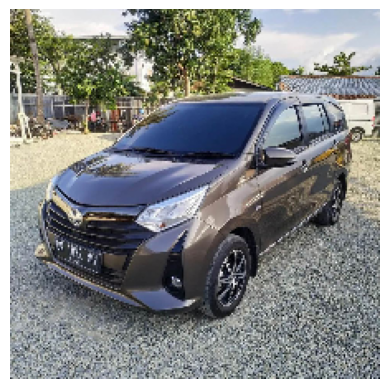

1/1 [==============================] - 0s 24ms/step

 Prediksi gambar adalah mobil


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import cv2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)

  plt.imshow(x/255.)
  plt.axis('off')
  plt.show()

  x = np.expand_dims(x, axis=0)
  classes = model.predict(x)
  
  if classes[0][0] < 0.5:
    print("\n Prediksi gambar adalah mobil")
  else:
    print("\n Prediksi gambar adalah motor")

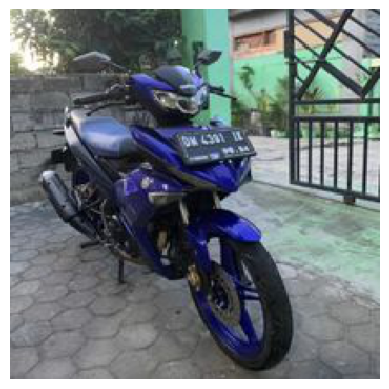

1/1 [==============================] - 0s 155ms/step
Hasil prediksi:  Motor


In [ ]:
# Impor library yang dibutuhkan
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Muat model yang sudah dilatih
model = load_model('vgg16_best.h5')

# Definisikan target size untuk image input
target_size = (224, 224)

# Muat gambar yang akan diuji
image = load_img('21.jpg', target_size=target_size)

# Konversi gambar menjadi array
image_array = img_to_array(image)

# Normalisasi array gambar
image_array = image_array.astype('float32')
plt.imshow(image_array/255.)
plt.axis('off')
plt.show()

# Reshape array gambar menjadi batch of size 1
image_array = np.expand_dims(image_array, axis=0)

# Prediksi label gambar menggunakan model
prediction = model.predict(image_array)

# Konversi hasil prediksi menjadi label kelas
if prediction < 0.5:
    label = 'Mobil'
else:
    label = 'Motor'

# Print hasil prediksi
print('Hasil prediksi: ', label)